In [221]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
from datetime import datetime as dt
from glob import glob
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

## Обработка исходных данных

In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
def parse_file(f):
  df = {'tick': [],
      'bids_prices': [],
      'bids_amounts': [],
      'asks_prices': [],
      'asks_amounts': [],
      'n_bids': [],
      'n_asks': [],
      'bid_price_mean': [],
      'bid_amount_sum': [],
      'ask_price_mean': [],
      'ask_amount_sum': [],
      'mid_price':[]}

  for line in f:
    line = line.split(' ')
    dct = ast.literal_eval(line[1])
    
    try:
      bids_prices = np.array(dct['bids'])[:,0]
      bids_amounts = np.array(dct['bids'])[:,1]
      n_bids = bids_prices.size
      bid_price_mean = np.mean(bids_prices)
      bid_amount_sum = np.sum(bids_amounts)
    except:
      bids_prices = np.nan
      bids_amounts = np.nan
      n_bids = np.nan
      bid_price_mean = np.nan
      bid_amount_sum = np.nan

    try:  
      asks_prices = np.array(dct['asks'])[:,0]
      asks_amounts = np.array(dct['asks'])[:,1]
      n_asks = asks_prices.size
      ask_price_mean = np.mean(asks_prices)
      ask_amount_sum = np.sum(asks_amounts)
    except:
      asks_prices = np.nan
      asks_amounts = np.nan
      n_asks = np.nan
      ask_price_mean = np.nan
      ask_amount_sum = np.nan

    tick = dt.strptime(line[0], '%Y-%m-%dT%H:%M:%S.%f')
    mid_price = np.mean([np.median(bids_prices), np.median(asks_prices)])

    df['tick'].append(tick)

    df['bids_prices'].append(bids_prices)
    df['bids_amounts'].append(bids_amounts)
    df['asks_prices'].append(asks_prices)
    df['asks_amounts'].append(asks_amounts)

    df['n_bids'].append(n_bids)
    df['n_asks'].append(n_asks)

    df['bid_price_mean'].append(bid_price_mean)
    df['bid_amount_sum'].append(bid_amount_sum)

    df['ask_price_mean'].append(ask_price_mean)
    df['ask_amount_sum'].append(ask_amount_sum)

    df['mid_price'].append(mid_price)

  return pd.DataFrame(df)

def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or  any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

In [224]:
df = None
for fname in glob('drive/MyDrive/Inv.Machine/binance*'):
  f = open(fname, 'r')
  df = weary_append(df, parse_file(f))

In [225]:
df.reset_index(drop=True).to_pickle('drive/MyDrive/Inv.Machine/data.pkl')

In [226]:
df = df.reset_index(drop=True)

## Генерация фичей

Я решил попробовать предсказывать mid-price через n тиков. Параметр n (глубина предскзания) потом надо подобрать. Несколько идей фичей, которые я собираюсь попробовать:
- Угловой коэффициент mid-price за последние $k_1$ тиков. Он должен уловить некоторый тренд изменения цены.
- Сумму за последние $k_2$ тиков числа запросов на продажу и покупку (n_bids и n_asks). Предполагаю что он должен влиять как спрос/предложение.
- Все возможные отношения вида $\frac{price}{amount}$ усредненный за последние $k_3$ дней.

In [228]:
df = pd.read_pickle('drive/MyDrive/Inv.Machine/data.pkl')

In [229]:
# Идентификация параметров
n = 5
k1 = 15
k2 = 5
k3 = 5

In [230]:
df['target'] = df['mid_price'].shift(-n)

df['angle'] = df['mid_price'] - df['mid_price'].shift(k1) # пока попробуем так. Плюс - быстро ситается

df['bids_sum'] = df['n_bids'].rolling(k2).sum()
df['asks_sum'] = df['n_asks'].rolling(k2).sum()

df['rel1'] = (df['bid_price_mean'] / df['bid_amount_sum']).rolling(k3).sum()
df['rel2'] = (df['bid_price_mean'] / df['ask_amount_sum']).rolling(k3).sum()
df['rel3'] = (df['ask_price_mean'] / df['bid_amount_sum']).rolling(k3).sum()
df['rel4'] = (df['ask_price_mean'] / df['ask_amount_sum']).rolling(k3).sum()

## Аналитика

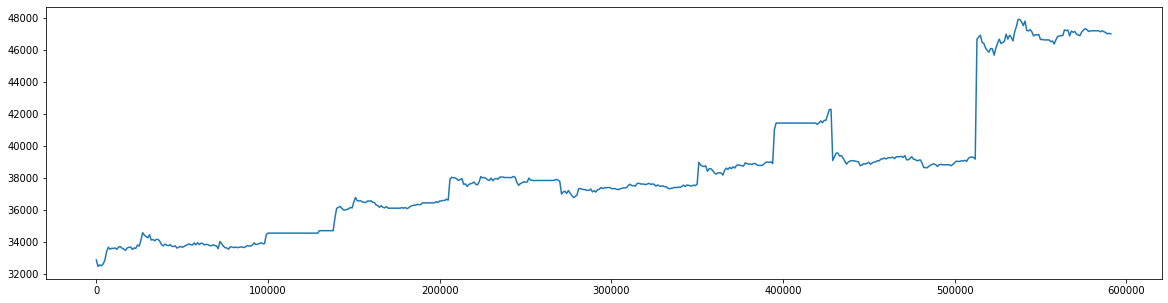

In [231]:
df[::100]['target'].plot(figsize=(20, 5))

## Модель. LGBM

In [274]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1', 'l2'},
    'n_jobs': -1,
    # 'seed': 20210317,
    'learning_rate': 0.01,
    'max_depth': 10
    }

In [275]:
# train-val-test split
df = df[df['target'].notna()].sort_values(by='tick')
test = df[-n:]
train_val = df[:-n]

train_ratio = 0.9
split_index = int(train_val.shape[0] * train_ratio)

train = train_val[:split_index]
valid = train_val[split_index:]

In [276]:
train.shape, valid.shape

((532381, 20), (59154, 20))

In [277]:
col_names = ['mid_price', 'angle', 'bids_sum',
                                'asks_sum', 'rel1', 'rel2', 'rel3', 'rel4']
                       

train_set = lgb.Dataset(train[col_names],
                        train.target,
                        feature_name=col_names)

val_set = lgb.Dataset(valid[col_names],
                        valid.target,
                        feature_name=col_names)

In [278]:
model = lgb.train(params, train_set, 
              num_boost_round = 10000,
              early_stopping_rounds = 50, 
              valid_sets = [train_set, val_set],
              verbose_eval = 50)

Training until validation scores don't improve for 50 rounds.
[50]	training's l1: 1351.45	training's l2: 4.95351e+06	valid_1's l1: 8926.01	valid_1's l2: 7.98384e+07
[100]	training's l1: 952.054	training's l2: 3.45959e+06	valid_1's l1: 8497.8	valid_1's l2: 7.25775e+07
[150]	training's l1: 712.388	training's l2: 2.82426e+06	valid_1's l1: 8211.49	valid_1's l2: 6.79672e+07
[200]	training's l1: 574.78	training's l2: 2.4903e+06	valid_1's l1: 7981.69	valid_1's l2: 6.43223e+07
[250]	training's l1: 418.107	training's l2: 1.72968e+06	valid_1's l1: 7057.57	valid_1's l2: 5.04036e+07
[300]	training's l1: 332.011	training's l2: 1.33892e+06	valid_1's l1: 6450.43	valid_1's l2: 4.21556e+07
[350]	training's l1: 280.052	training's l2: 1.14138e+06	valid_1's l1: 6082.39	valid_1's l2: 3.75201e+07
[400]	training's l1: 248.858	training's l2: 1.03568e+06	valid_1's l1: 5859.14	valid_1's l2: 3.48434e+07
[450]	training's l1: 230.088	training's l2: 976700	valid_1's l1: 5723.96	valid_1's l2: 3.32716e+07
[500]	train

In [279]:
model.params

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 10,
 'metric': {'l1', 'l2'},
 'n_jobs': -1,
 'objective': 'regression_l1'}

In [280]:
model.feature_importance()

array([29167,  7142,   520,   279,  2186,  3545,  1628,  2123])

## Проверка на test

In [263]:
test['prediction'] = model.predict(test[col_names])
print('MAE on test: ', mean_absolute_error(test['target'], test['prediction']))
print('MAE on test with current mid-price: ', mean_absolute_error(test['target'], test['mid_price']))

MAE on test:  34.79107574712543
MAE on test with current mid-price:  6.157500000001164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [264]:
test[['target', 'prediction', 'mid_price']]

,target,prediction,mid_price
591536,46977.3425,47018.008088,46993.8100
591537,46978.0200,47018.419585,46979.3650
591538,46978.5650,47021.399681,46977.8575
591539,46987.7700,47013.171464,46984.8725
591540,46991.8275,47016.481561,46982.4575
